In [210]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [211]:
from copulas import *
import ndtest # bivariate Kolmogorov-Smirnov

In [212]:
from pandas_datareader import data
import yfinance as yfin
def get(tickers, start, end):
    def multiple(ticker):
        return yfin.download(ticker, start, end, progress=False)
    datas = map(multiple, tickers)
    return pd.concat(datas, keys=tickers,names=['Ticker', 'Date'])

In [213]:
tickers = ["ABCAPITAL.NS","CANFINHOME.NS"]
start = pd.to_datetime('2019-07-04')
end = pd.to_datetime('2022-01-03')
df = get(tickers, start, end)
adj_close = df.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
returns = np.log(adj_close).diff().dropna()
returns

Ticker,ABCAPITAL.NS,CANFINHOME.NS
Date,,
2019-07-05,-0.016078,0.006960
2019-07-08,-0.037990,0.004981
2019-07-09,0.008939,0.015835
2019-07-10,-0.004459,-0.000546
2019-07-11,0.006126,0.022169
...,...,...
2021-12-27,0.026804,0.009476
2021-12-28,0.005443,0.014092
2021-12-29,0.032857,-0.018142


<Axes: xlabel='Date'>

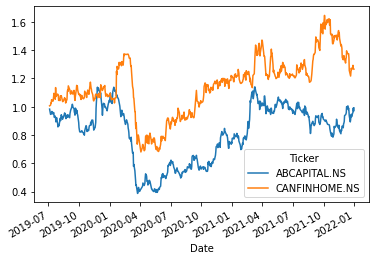

In [214]:
(returns+1).cumprod().plot()

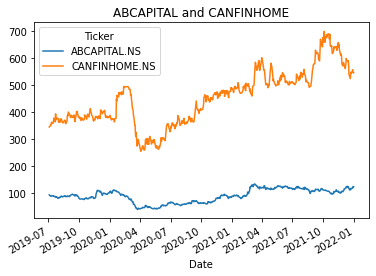

In [215]:
adj_close.plot()
plt.title('ABCAPITAL and CANFINHOME')
plt.show()

In [216]:
returns.columns=['ABCAPITAL','CANFINHOME']
tickers=['ABCAPITAL','CANFINHOME']
tickers

['ABCAPITAL', 'CANFINHOME']

In [217]:
stats.kendalltau(returns['ABCAPITAL'], returns['CANFINHOME'])[0]

0.20831770664968588

In [218]:
returns

,ABCAPITAL,CANFINHOME
Date,,
2019-07-05,-0.016078,0.006960
2019-07-08,-0.037990,0.004981
2019-07-09,0.008939,0.015835
2019-07-10,-0.004459,-0.000546
2019-07-11,0.006126,0.022169
...,...,...
2021-12-27,0.026804,0.009476
2021-12-28,0.005443,0.014092
2021-12-29,0.032857,-0.018142


{0.03510307225903031, -2556.13839235431, <scipy.stats._continuous_distns.norm_gen object at 0x000002C262BC1520>, -2564.9913692692253, 'ABCAPITAL'}
{0.8241884455387558, -2617.75442305745, <scipy.stats._continuous_distns.t_gen object at 0x000002C262C2CAC0>, -2604.474957685077, 'ABCAPITAL'}
{0.6375844308755777, -2611.5840070320573, <scipy.stats._continuous_distns.genlogistic_gen object at 0x000002C262BE6970>, -2598.304541659684, 'ABCAPITAL'}


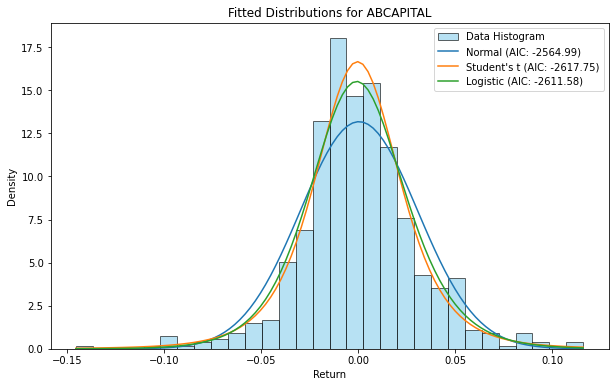

{0.024188929556138272, -2716.707521423596, -2707.8545445086806, <scipy.stats._continuous_distns.norm_gen object at 0x000002C262BC1520>, 'CANFINHOME'}
{-2784.443643647745, 0.8694719240312692, <scipy.stats._continuous_distns.t_gen object at 0x000002C262C2CAC0>, -2797.723109020118, 'CANFINHOME'}
{0.6033845812169867, -2773.0372316992857, 'CANFINHOME', <scipy.stats._continuous_distns.genlogistic_gen object at 0x000002C262BE6970>, -2786.316697071659}


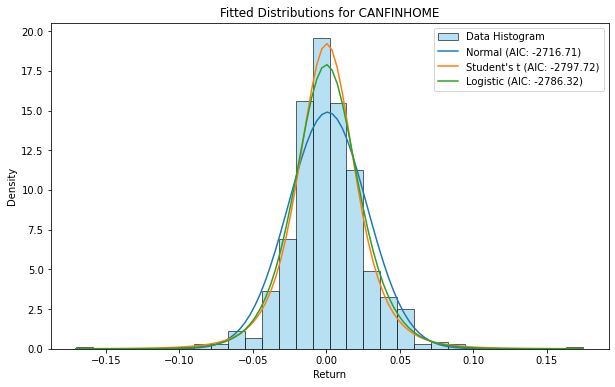

                 Stock Distribution          AIC          BIC  KS_pvalue
ABCAPITAL    ABCAPITAL  Student's t -2617.754423 -2604.474958   0.824188
CANFINHOME  CANFINHOME  Student's t -2797.723109 -2784.443644   0.869472


In [219]:
marginals_df = pd.DataFrame(columns=['Stock','Distribution', 'AIC', 'BIC', 'KS_pvalue'])
for stock in tickers:
    data = returns[stock]
    dists = ['Normal', "Student's t", 'Logistic']
    best_aic = np.inf
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label="Data Histogram")
    for dist, name in zip(
        [stats.norm, stats.t, stats.genlogistic, stats.genextreme, stats.genpareto, stats.triang], 
        dists
    ):
        try:
            # Fit distribution parameters
            if name == 'Triangular':
                c = (data.mean() - data.min()) / (data.max() - data.min())
                params = (c, data.min(), data.max() - data.min())
            else:
                params = dist.fit(data)

            # Create frozen distribution instance
            dist_fit = dist(*params)
            
            # Calculate log-likelihood, AIC, and BIC
            log_like = np.log(dist_fit.pdf(data)).sum()
            aic = 2 * len(params) - 2 * log_like
            bic = len(params) * np.log(len(data)) - 2 * log_like
            
            # Perform K-S test
            ks_pval = stats.kstest(data, dist_fit.cdf, N=100)[1]
            print({stock,dist,aic,bic,ks_pval})
            # Update best distribution based on AIC
            if aic < best_aic:
                best_dist = name
                best_aic = aic
                best_bic = bic
                best_ks_pval = ks_pval

            # Plot the PDF of the fitted distribution
            x = np.linspace(data.min(), data.max(), 100)
            plt.plot(x, dist_fit.pdf(x), label=f"{name} (AIC: {aic:.2f})")

        except Exception as e:
            print(f"Error fitting {name} distribution for {stock}: {e}")

    # Store results in DataFrame
    marginals_df.loc[stock] = [stock,best_dist, best_aic, best_bic, best_ks_pval]

    # Finalize plot
    plt.title(f"Fitted Distributions for {stock}")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

print(marginals_df)

In [220]:
marginals_df = pd.DataFrame(index=tickers, columns=['Distribution', 'AIC', 'BIC', 'KS_pvalue'])
for stock in tickers:
    data = returns[stock]
    dists = ['Normal', "Student's t", 'Logistic', 'Extreme','GenPareto','Triangular']
    best_aic = np.inf
    for dist,name in zip([stats.norm, stats.t, stats.genlogistic, stats.genextreme], dists):
        params = dist.fit(data)
        dist_fit = dist(*params)
        log_like = np.log(dist_fit.pdf(data)).sum()
        aic = 2*len(params) - 2 * log_like
        if aic<best_aic:
            best_dist = name
            best_aic = aic
            best_bic = len(params) * np.log(len(data)) - 2 * log_like
            ks_pval = stats.kstest(data, dist_fit.cdf, N=100)[1]
    marginals_df.loc[stock] = [best_dist, best_aic, best_bic, ks_pval]
marginals_df

,Distribution,AIC,BIC,KS_pvalue
ABCAPITAL,Student's t,-2617.754423,-2604.474958,0.824188
CANFINHOME,Student's t,-2797.723109,-2784.443644,0.869472


In [221]:
pair = ('ABCAPITAL','CANFINHOME')
s1,s2 = pair
copulas_df = pd.DataFrame(columns=['parameter', 'aic', 'bic', 'KS_pvalue'])

# fit marginals
params_s1 = stats.t.fit(returns[s1])
dist_s1 = stats.t(*params_s1)
params_s2 = stats.t.fit(returns[s2])
dist_s2 = stats.t(*params_s2)
# apply probability integral transform
u = dist_s1.cdf(returns[s1])
v = dist_s2.cdf(returns[s2])


#for copula in [GaussianMultivariate()]:
for copula in [GaussianCopula(), ClaytonCopula(), GumbelCopula(), FrankCopula(), JoeCopula()]:
    copula.fit(u,v)
    L = copula.log_likelihood(u,v)
    aic = 2 * copula.num_params - 2 * L
    bic = copula.num_params * np.log(len(u)) - 2 * L
    copula_name = copula.name
    
    # calculate KS-pvalue
    smp = copula.sample(size=len(u)) # generate sample from fit copula
    s_u = smp[:,0]
    s_v = smp[:,1]
    ks_pval = ndtest.ks2d2s(u,v,s_u,s_v)
    
    if isinstance(copula, ArchimedeanCopula):
        best_param = copula.alpha
    else:
        best_param = copula.rho
    #print([copula_name, best_param, aic, bic, ks_pval])
    copulas_df.loc[copula_name] = [best_param, aic, bic, ks_pval]
copulas_df.to_csv('Copula_result.csv')
copulas_df

c:\Users\cheta\OneDrive\Documents\BTP\BTP_New Code\copulas.py:322: RuntimeWarning: invalid value encountered in power
  num = (u**(-alpha) * v**(-alpha) * (alpha+1) * (-1 + v**(-alpha) + u**(-alpha))**(-1/alpha))
c:\Users\cheta\OneDrive\Documents\BTP\BTP_New Code\copulas.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(self.pdf(u,v)).sum()


,parameter,aic,bic,KS_pvalue
Gaussian,0.321416,-307.090829,-302.664340,0.388502
Clayton,0.623579,-112.772591,-108.346102,0.550955
Gumbel,1.194117,-40.615089,-36.188601,0.003280
Frank,1.949070,-59.168111,-54.741622,0.224861
Joe,1.162146,-14.983699,-10.557211,0.102375


In [222]:
tickers = ['ABCAPITAL.ns','CANFINHOME.ns']
s1 = "ABCAPITAL"
s2 = "CANFINHOME"
start = pd.to_datetime('2010-01-01')
end = pd.to_datetime('2024-11-03')
df = get(tickers, start, end)
adj_close = df.reset_index().pivot(index='Date', columns='Ticker', values='Adj Close')
returns_test = np.log(adj_close).diff().dropna()
returns_test

Ticker,ABCAPITAL.ns,CANFINHOME.ns
Date,,
2017-09-04,-0.051183,-0.020442
2017-09-05,-0.051142,0.016579
2017-09-06,-0.051195,0.007695
2017-09-07,0.015829,-0.001056
2017-09-08,-0.027929,-0.008855
...,...,...
2024-10-28,-0.000246,-0.003415
2024-10-29,0.008101,0.017365
2024-10-30,0.051741,0.025411


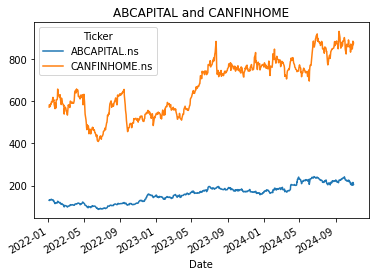

In [223]:
adj_close.loc['2022-1-04':'2024-11-03',:].plot()
plt.title('ABCAPITAL and CANFINHOME')
plt.show()

In [224]:
def get_prob_trading(data_source,fitting_period,predicting_period,start,end):
    '''
    calculate conditional probability based on Copula joint distribution
    '''
    
    s1,s2 = data_source.columns
    all_time_index = data_source.index
    trading_time_index = data_source.loc[start:end].index
    end_loc = all_time_index.get_loc(trading_time_index[-1])
    prob_s1 = []
    prob_s2 = []
    cnts = []

    for t in trading_time_index[::predicting_period]:
        start_loc = all_time_index.get_loc(t)
        if start_loc < fitting_period:
            print(f"Skipping index {start_loc} due to insufficient data for fitting period.")
            continue
        fitting_return = data_source.iloc[start_loc-fitting_period:start_loc]
        predicting_return = data_source.iloc[start_loc:min(start_loc+predicting_period,end_loc+1)]
        
        # fit marginals
        # print("fitting_return[s1]:", fitting_return[s1])
        # print("fitting_return[s2]:", fitting_return[s2])
        params_s1 = stats.t.fit(fitting_return[s1])
        dist_s1 = stats.t(*params_s1)
        params_s2 = stats.t.fit(fitting_return[s2])
        dist_s2 = stats.t(*params_s2)

        # transform marginals
        u = dist_s1.cdf(fitting_return[s1])
        v = dist_s2.cdf(fitting_return[s2])

        copulas = GaussianCopula()
        copulas.fit(u,v)

        cnt = 0

        for u,v in zip(dist_s1.cdf(predicting_return[s1]), dist_s2.cdf(predicting_return[s2])):
            cnt += 1
            prob_s1.append(copulas.cdf_u_given_v(u,v))
            prob_s2.append(copulas.cdf_v_given_u(u,v))

        cnts.append((cnt, t))

    print(cnts)
    vals = np.vstack([prob_s1, prob_s2]).T
    probs_trade = pd.DataFrame(vals, index=trading_time_index, columns=[s1, s2])
    return probs_trade

In [225]:
def pair_strategy(data_source,probs_trade,cl,cl_close):
    '''
    conduct pairs trading based on conditional probability
    '''
    s1 = probs_trade.columns[0]
    s2 = probs_trade.columns[1]
    positions = pd.DataFrame(index=probs_trade.index, columns=probs_trade.columns)
    long = False
    short = False
    for t in positions.index:    
        # if long position is open
        if long:
            if (probs_trade.loc[t][s1] > (1-cl_close)) or (probs_trade.loc[t][s2] < cl_close):
                positions.loc[t] = [0,0]
                long = False
            else:
                positions.loc[t] = [1,-1]

        # if short position is open
        elif short:
            if (probs_trade.loc[t][s1] < cl_close) or (probs_trade.loc[t][s2] > (1-cl_close)):
                positions.loc[t] = [0,0]
                short = False
            else:
                positions.loc[t] = [-1,1]

        # if no positions are open
        else:
            if (probs_trade.loc[t][s1] < (1-cl)) and (probs_trade.loc[t][s2] > cl):
                # open long position
                positions.loc[t] = [1,-1]
                long = True
            elif (probs_trade.loc[t][s1] > cl) and (probs_trade.loc[t][s2] < (1-cl)):
                # open short positions
                positions.loc[t] = [-1,1]
                short = True
            else:
                positions.loc[t] = [0,0]

    # calculate returns
    returns_trade = data_source.loc[probs_trade.index]
    algo_returns = {}
    algo_ret = (returns_trade * positions.shift(1)).sum(axis=1)
    algo_returns['pair'] = algo_ret
    returns_df = pd.DataFrame.from_dict(algo_returns)
    returns_df = returns_df.apply(pd.to_numeric, errors='coerce').astype(float)
    returns_df = np.exp(returns_df) - 1 # convert log-returns to simple returns
    total_ret = returns_df.sum(axis=1) / len(returns_df.columns) * 2 # double capital (from short positions)

    a = pd.DataFrame(data={'algo':np.nancumprod(total_ret + 1),s1:np.nancumprod(returns_trade[s1] + 1),s2:np.nancumprod(returns_trade[s2] + 1)},index=probs_trade.index)
    return a

In [226]:
fitting_period = 500
predicting_period = 100
start = '2022-1-04'
end = '2024-11-03'
probs_trade = get_prob_trading(returns_test,fitting_period,predicting_period,start,end)

[(100, Timestamp('2022-01-04 00:00:00')), (100, Timestamp('2022-06-01 00:00:00')), (100, Timestamp('2022-10-25 00:00:00')), (100, Timestamp('2023-03-20 00:00:00')), (100, Timestamp('2023-08-16 00:00:00')), (100, Timestamp('2024-01-11 00:00:00')), (99, Timestamp('2024-06-12 00:00:00'))]


In [227]:
returns

,ABCAPITAL,CANFINHOME
Date,,
2019-07-05,-0.016078,0.006960
2019-07-08,-0.037990,0.004981
2019-07-09,0.008939,0.015835
2019-07-10,-0.004459,-0.000546
2019-07-11,0.006126,0.022169
...,...,...
2021-12-27,0.026804,0.009476
2021-12-28,0.005443,0.014092
2021-12-29,0.032857,-0.018142


In [228]:
df_normalized = returns.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) )
data1=df_normalized['ABCAPITAL']
data2=df_normalized['CANFINHOME']

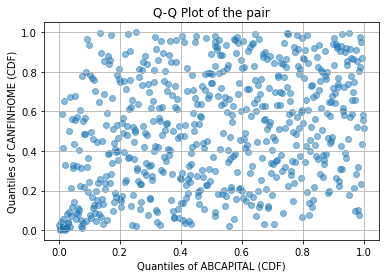

In [229]:
cdf1 = stats.rankdata(data1) / len(data1)  # Empirical CDF for data1
cdf2 = stats.rankdata(data2) / len(data2)  # Empirical CDF for data2

plt.scatter(cdf1, cdf2, alpha=0.5)
plt.title("Q-Q Plot of the pair")
plt.xlabel("Quantiles of ABCAPITAL (CDF)")
plt.ylabel("Quantiles of CANFINHOME (CDF)")
plt.grid(True)
plt.show()

In [230]:
probs_trade

,ABCAPITAL.ns,CANFINHOME.ns
Date,,
2022-01-04,0.605676,0.659996
2022-01-05,0.215185,0.859502
2022-01-06,0.895503,0.238618
2022-01-07,0.530044,0.331430
2022-01-10,0.320217,0.864772
...,...,...
2024-10-28,0.517867,0.378976
2024-10-29,0.464639,0.794538
2024-10-30,0.952980,0.585808


<Axes: xlabel='Date'>

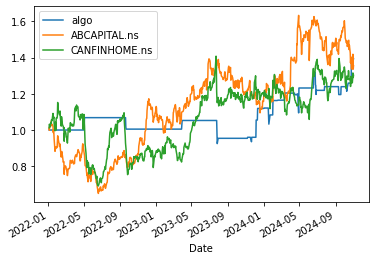

In [239]:
cl = 0.90
cl_close = 0.5
pair_strategy(returns_test,probs_trade,cl,cl_close).plot()

Text(0.5, 1.0, 'the performance of Pairs Trading compared with indexes')

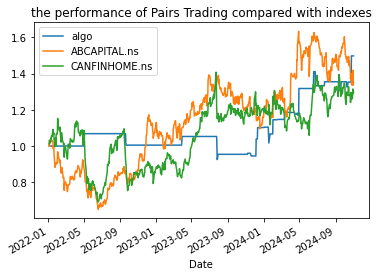

In [232]:
cl = 0.90
cl_close = 0.65
pair_strategy(returns_test,probs_trade,cl,cl_close).plot()
plt.title('the performance of Pairs Trading compared with indexes')

In [233]:
def calculate_metrics(cumret):
    '''
    calculate performance metrics from cumulative returns
    '''
    total_return = (cumret[-1] - cumret[0])/cumret[0]
    apr = (1+total_return)**(252/len(cumret)) - 1
    rets = pd.DataFrame(cumret).pct_change()
    sharpe = np.sqrt(252) * np.nanmean(rets) / np.nanstd(rets)
    
    # maxdd and maxddd
    highwatermark=np.zeros(cumret.shape)
    drawdown=np.zeros(cumret.shape)
    drawdownduration=np.zeros(cumret.shape)
    for t in np.arange(1, cumret.shape[0]):
        highwatermark[t]=np.maximum(highwatermark[t-1], cumret[t])
        drawdown[t]=cumret[t]/highwatermark[t]-1
        if drawdown[t]==0:
            drawdownduration[t]=0
        else:
            drawdownduration[t]=drawdownduration[t-1]+1
    maxDD=np.min(drawdown)
    maxDDD=np.max(drawdownduration)
    
    return total_return, apr, sharpe, maxDD

In [235]:
total_ret = pair_strategy(returns_test,probs_trade,0.9,0.5)
metrics = pd.DataFrame(columns=['Total return', 'APR', 'Sharpe', 'MaxDD'])
metrics.loc['algo'] = calculate_metrics(total_ret['algo'])
metrics.loc['ABCAPITAL.ns'] = calculate_metrics(total_ret['ABCAPITAL.ns'])
metrics.loc['CANFINHOME.ns'] = calculate_metrics(total_ret['CANFINHOME.ns'])
metrics

,Total return,APR,Sharpe,MaxDD
algo,0.393754,0.127149,0.745445,-0.134248
ABCAPITAL.ns,0.341201,0.111638,0.482553,-0.379049
CANFINHOME.ns,0.286227,0.094991,0.435066,-0.399971
